# 4. Обработка пленоптических фотографий

Это 4 задание курса "Интеллектуальные методы обработки видео"

Репозиторий курса:
https://github.com/msu-video-group/video-course

Курс в anytask:
https://anytask.org/course/465

Данное задание состоит из нескольких основных частей. **Оно не является конкурсным**, за каждое подзадание можно получить максимальное качество баллов за приемлемую работу. Интересные мысли и красивая реализация приветствуется.

## Часть 1. Lytro Light Field Camera (8 баллов)

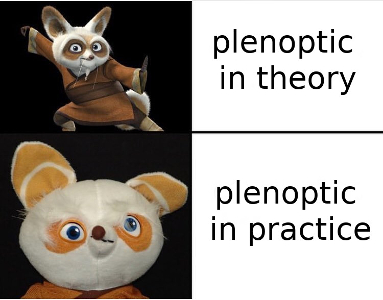

В 2011 году появилась камера Lytro Light Field Camera. Вот краткое описание формата пикселей:
* Базовое разрешение 3280x3280
* Линзы в массиве упакованы "как соты" (поэтому каждый второй ряд на полпикселя сдвинут относительно другого)
* Под каждой линзой нецелое количество пикселей по высоте и ширине
* Более того, этот массив микролинз немного повёрнут относительно массива пикселей

В этой части задания и попробуем руками получить хоть что-то красивое из сырых изображений, а также научися сдвигать наблюдателя в плоскости объектива

**Для начала откроем изображение**

In [ ]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
from IPython.display import Image as ImageDisplay
from tqdm import tqdm_notebook 
import imageio
image = skimage.io.imread('bee.png')
image = image / image.max()

In [ ]:
image_array = np.array(image)
plt.figure(figsize=(16, 16))
plt.imshow(image_array, cmap='gray')
plt.show()

Увеличим его часть:

In [ ]:
image_array = np.array(image)
plt.figure(figsize=(16, 16))
plt.imshow(image_array[1000:1100, 2090:2190], cmap='gray')
plt.show()

Чётко прослеживается структура массива линз, кроме того, видим, что и внутри линз есть своя структура - некоторые пиксели регулярно темнее/светлее остальных. Дело в том, что изначально каждый фотодиод фотоматриц принимает только определённый цвет изображения, так как [накрыт цветным фильтром](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D0%91%D0%B0%D0%B9%D0%B5%D1%80%D0%B0).

Преобразуем сырые данные камеры в RGB-изображение. Для этого:
* Составим маску красных, синих и зелёных каналов на сыром изображении
* Произведём интерполяцию путём усреднения соседних известных значений канала

Первый шаг - составление маски. Начиная с левого верхнего угла, цвет хранится так:
<table><tr><td bgcolor="#0000FF"></td><td bgcolor="#00FF00"></td></tr><tr><td bgcolor="#00FF00"></td><td bgcolor="#FF0000"></td></tr></table>
Напишите функцию, которая по заданной высоте и ширине изображения составит маски каналов (4 матрицы, значение элемента внутри которых равно единице в пикселях, который содержит B, G1, G2 или R компоненту соответственно).
Например, для изображения $2x2$ матрица для цветовой компоненты B выглядит так:
$$ \quad
\begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}
\quad $$

Обратите внимание, что G-канал разделён на два для последующего удобства обработки.

In [ ]:
# Подзказка: объявите массивы-маски 2x2 и затем используйте np.tile
# В Lytro формат цвета такой
# B G1
# G2 R
def get_bayer_pattern_masks(h, w):
    '''
    Возвращает 4 маски заданной высоты и ширины для сырого изображения формата
    B G1
    G2 R
    :param h: int, height of bayer pattern
    :param w: int, width of bayer pattern
    :return [numpy.ndarray((h, w)), numpy.ndarray((h, w)), numpy.ndarray((h, w)), numpy.ndarray((h, w))]
    маски для B-компоненты, G1-компоненты, G2-компоненты и R-компоненты
    '''
    # YOUR CODE
    return # YOUR CODE

Следующий шаг - интерполяция каналов. Действовать будем по [этой статье](http://www.cis.rit.edu/~cnspci/references/dip/demosaicking/malvar2004.pdf). Суть её заключается в том, что для каждого из четырёх типов пикселей мы вычисляем веса неизвестных каналов следующим способом:

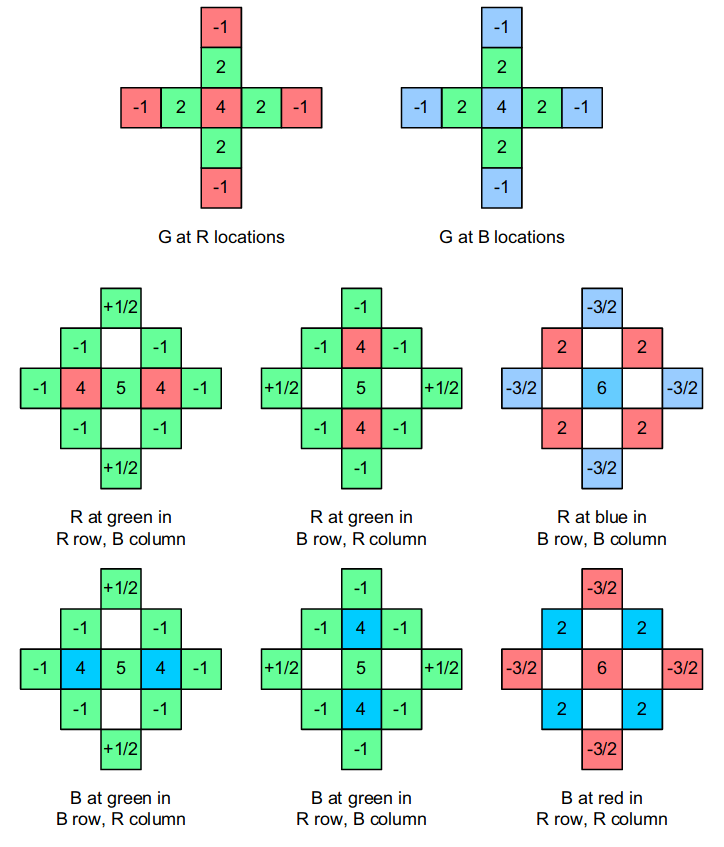

In [ ]:
def high_quality_bayer_interpolation(raw_image):
    h = raw_image.shape[0]
    w = raw_image.shape[1]
    
    weigths_0 = (1 / 8) * np.array([
        [ 0,  0, 1/2,  0,  0],
        [ 0, -1,   0, -1,  0],
        [-1,  4,   5,  4, -1],
        [ 0, -1,   0, -1,  0],
        [ 0,  0, 1/2,  0,  0]
    ])

    weigths_1 = (1 / 8) * np.array([
        [  0,  0,  -1,  0,   0],
        [  0, -1,   4, -1,   0],
        [1/2,  0,   5,  0, 1/2],
        [  0, -1,   4, -1,   0],
        [  0,  0,  -1,  0,   0]
    ])

    weigths_2 = (1 / 8) * np.array([
        [   0,  0, -3/2,  0,    0],
        [   0,  2,    0,  2,    0],
        [-3/2,  0,    6,  0, -3/2],
        [   0,  2,    0,  2,    0],
        [   0,  0, -3/2,  0,    0]
    ])

    weigths_3 = (1 / 8) * np.array([
        [ 0,  0, -1,  0,  0],
        [ 0,  0,  2,  0,  0],
        [-1,  2,  4,  2, -1],
        [ 0,  0,  2,  0,  0],
        [ 0,  0, -1,  0,  0]
    ])

    image = np.zeros((h, w, 3), dtype=np.float)
    mask_r, mask_g1, mask_g2, mask_b = get_bayer_pattern_masks(h, w)
    
   # YOUR CODE

    return np.clip(image, 0, 1)

In [ ]:
image_interpolated = high_quality_bayer_interpolation(image_array)

In [ ]:
plt.figure(figsize=(32, 32))
plt.imshow(image_interpolated, cmap='gray')
plt.show()

**Ура!** Теперь осталось его правильно обработать. Давайте реализуем сдвиг по вертикали и горизонтали.

В простейшем случае процесс описан в [этой ссылке](http://www.plenoptic.info/pages/sub-aperture.html) (только параграф про получение Sub-apertures!). По сути, нужно выбрать пиксели внутри каждого блока с некоторым сдвигом

In [ ]:
plenoptic_image_config = {
    'block_width': 9.927582228653469,
    'block_height': 8.607538408172838
}

In [ ]:
second_row_shift = 0
first_row_shift = 5
def baseline_move(plenoptic_raw_image, plenoptic_image_config, position_shift_y, position_shift_x):
    raw_image_height = plenoptic_raw_image.shape[0]
    raw_image_width = plenoptic_raw_image.shape[1]
    block_height = plenoptic_image_config['block_height']
    block_width = plenoptic_image_config['block_width']
    block_count_h = int(raw_image_height // block_height)
    block_count_w = int(raw_image_width // block_width)
    result = np.zeros((block_count_h, block_count_w, 3))
    
    # Учтите, что высота линзы и её ширина не равна целому числу пикселей 
    # поэтому не пренебрегайте использования магическими константами 
    # (block_height - высота линзы, block_width - её ширина). 
    # Также учтите, что каждый второй ряд сдвинут относительно первого.
    # Замечание: написать вложенные циклы тут ОК
   
    return result

In [ ]:
images = []
for dx in tqdm_notebook(range(-3, 5, 1)):
    for dy in range(-4, 5, 1):
        image = baseline_move(image_interpolated, plenoptic_image_config, dy, dx)
        images.append(image)

In [ ]:
output_file='baseline_move.gif'
import imageio
duration = 1
imageio.mimsave(output_file, images, duration=duration)

In [ ]:
with open('baseline_move.gif','rb') as f:
    display(ImageDisplay(data=f.read(), format='png'))

*Что ожидается увидеть: заметное движение заднего фона, однако, яркость изображений будет отличаться, это нормально. Кроме того, возможны небольшие горизонтальные/вертикальные полоски.*.

Несоответствие по яркости происходит из-за того, что из-за массива микролинз свет падает неравномерно на массив пикселей, а при дебайеринге мы никак не учитывали этот факт.
Попробуем отнормировать изображения по цвету. Для этого воспользуйтесь функцией [match_histograms](http://scikit-image.org/docs/dev/auto_examples/transform/plot_histogram_matching.html)


In [ ]:
images = []

# YOUR CODE

for dx in tqdm_notebook(range(-3, 4, 1)):
    for dy in range(-3, 4, 1):
        image = baseline_move(image_interpolated, plenoptic_image_config, dy, dx)
        # YOUR CODE
        images.append(image)

In [ ]:
output_file='baseline_move_with_histograms.gif'
duration = 1
imageio.mimsave(output_file, images, duration=duration)

In [ ]:
with open('baseline_move_with_histograms.gif','rb') as f:
    display(ImageDisplay(data=f.read(), format='gif'))

## Часть 2. Немного 3D (7 баллов)

В этом подзадании требуется получить [анаглифное](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D0%B0%D0%B3%D0%BB%D0%B8%D1%84) изображение на основе полученных данных. План приблизительно следующий:
* Создайте два изображения с максимальным параллаксом (горизонтальным расстоянием между виртуальными камерами)
* Наложите их друг на друга, используя цветовые фильтры
* Получите ещё больше баллов за небольшой анализ (пробуйте уменьшать/увеличивать параллакс, создаёте gif-картинку). Что будет, если изначально накладывать изображения с небольшим сдвигом?

## The end?

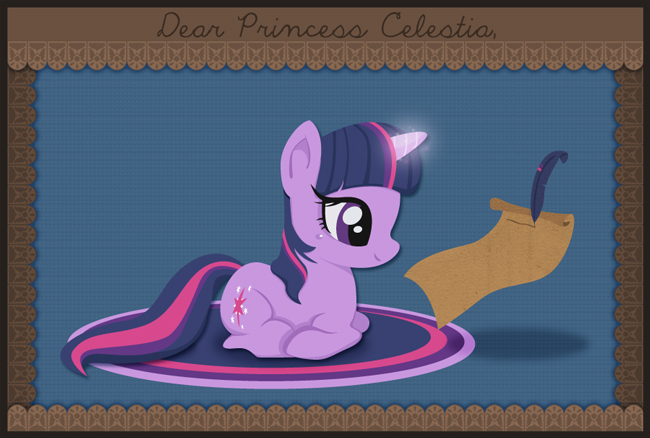

*Пожалуйста, напишите ниже в свободной форме вашу боль от задания: что понравилось, что не понравилось*